# Diagonalizing a Hamiltonian (PDE eigenvalue problems)

## Solving the Schrodinger Equation for a 2d Harmonic oscillator

In this example, we will show how to use the CoLA library to solve for the eigenvalues and eigenfunctions of the Hamiltonian operator for a two-dimensional quantum harmonic oscillator. The Hamiltonian operator is defined as

H = -Δ/2 + V(x)

where Δ is the Laplacian operator and V(x) is the potential energy function. We will be using a discretized Laplacian on a square grid and a simple harmonic potential V(x) = x²/2.

To start, let's create a 1000 x 1000 point coordinate mesh:

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import jax
import cola
from jax.config import config; config.update("jax_enable_x64", False)
#jax.config.update('jax_platform_name', 'cpu')

N = 300
ndims = 2
grid = jnp.linspace(-30,30,N)
dx = grid[1]-grid[0]
xyz = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)

Here, N is the number of points in each dimension, ndims is the number of dimensions, and grid represents the grid points from -30 to 30. dx represents the grid spacing, and xyz is an array of 2D points representing the coordinates of each point in the grid.

Next, we define the Laplacian operator. We use the same finite difference stencil as in the previous example to discretize the Laplacian.

In [2]:
def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

L = cola.ops.LinearOperator(jnp.float32, shape=(N**ndims, N**ndims), matmat=jit(vmap(laplacian, -1, -1)))

The function laplacian calculates the second derivative along each dimension and sums them up. The result is reshaped to a 1D array and returned.

Next, we define the potential function V(x) as a diagonal operator:

In [3]:
def vfn(x):
    return (x * x).sum() / 2

V = cola.diag(vmap(vfn)(xyz).reshape(-1))

vfn calculates the potential energy for a given point in the grid. cola.diag creates a diagonal operator with the calculated potential energy values on the diagonal. vmap is a function from the JAX library that applies the function vfn to each point in xyz.

Next, we define the Hamiltonian operator and compute its eigenvalues and eigenvectors:

In [4]:
H = -L / 2 + V
energy_levels, eigenfunctions = cola.eig(cola.SelfAdjoint(H),max_iters=500, tol=1e-4, method='iterative', pbar=True)
eigenfunctions = eigenfunctions.to_dense()

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

/home/marc_f/cola/cola/jax_fns.py:248: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(arr, dtype=dtype)


The Hamiltonian operator H is defined as the sum of the kinetic energy operator (-Δ/2) and the potential energy operator (V). The cola.SelfAdjoint function is used to inform CoLA that H is a symmetric operator which makes the eigenvalue calculation more efficient.

We then plot the lowest several eigenvalues:

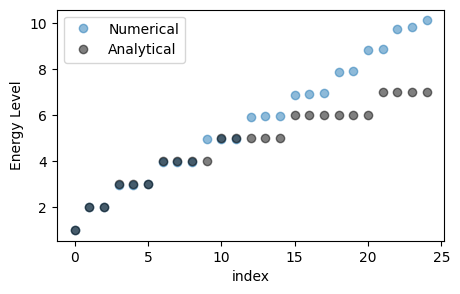

In [5]:
nm = np.stack(np.meshgrid(np.arange(10),np.arange(10)), axis=-1).reshape(-1, 2)
Enm = 1+nm[:,0]+nm[:,1]
nm = nm[Enm.argsort()]
Enm = np.sort(Enm)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(5, 3))
axs.plot(energy_levels[:25], 'o',alpha=0.5, label="Numerical")
axs.plot(Enm[:25], 'o', color='k',alpha=0.5, label="Analytical")
plt.legend()
plt.xlabel("index")
plt.ylabel("Energy Level")
plt.show()

Each point represents an eigenvalue, which corresponds to an energy level of the quantum harmonic oscillator. Up to errors produced by the finite boundary (at [-30,30]) and discretization, we see the familiar $E_{nm} = (1/2+n)+(1/2+m)$ energy levels for the 2d oscillator.

Lastly, we visualize the corresponding eigenfunctions:

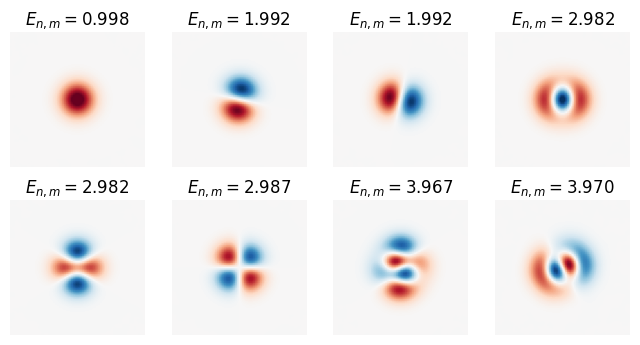

In [6]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for i,ax in enumerate(axs.flatten()):
    l = 30
    ax.imshow(eigenfunctions[:, i].reshape(N,N)[N//2-l:N//2+l,N//2-l:N//2+l],
    extent=[grid[N//2-l],grid[N//2+l],grid[N//2+l],grid[N//2-l]],
    cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax.set_title(r"$E_{{{}}} ={:.3f}$".format("n,m",energy_levels[i]))
    ax.axis('off')

Each subplot represents an eigenfunction, reshaped to 2D and displayed as an image. The eigenfunctions correspond to the wave functions of the quantum harmonic oscillator at different energy levels. The color represents the value of the wave function at each point in the grid. The title of each subplot shows the corresponding eigenvalue, or energy level.

Through this example, we have shown how to solve for the energy levels and wave functions of a quantum harmonic oscillator using the CoLA library.

## Solving the Schrodinger Eq for the Hydrogen atom in 3d, diagonalizing non hermitian Hamiltonians via compactifying transform

In [ ]:
# e3 = jnp.linalg.eigvalsh(H.to_dense())
# print(np.sort(e3)[:10])

/data/users/marc_f/cola/cola/ops.py:78: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self @ self.xnp.eye(self.shape[-1], dtype=self.dtype)


[ 41.57455   41.575943  41.576588  41.577152  41.5774    41.57964
  41.582     41.584194 152.37383  152.37447 ]


In [1]:
import os
import time
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import jax
from jax import jacfwd
from jax.config import config
import cola
from jax.config import config; config.update("jax_enable_x64", True)
#jax.config.update('jax_platform_name', 'cpu')

def square_compactification(x):
    return jnp.arctan(x) * 2 / jnp.pi


def inv_square_compactification(y):
    return jnp.tan(y * jnp.pi / 2)


# define the hydrogen atom Hamiltonian transformed coordinates
N = 100
ndims = 2

grid = jnp.linspace(-1 + .001, 1 - .001, N)  # convert to 3d with meshgrid

# grid = jnp.linspace(-1,1,N)
# grid = jnp.linspace(-40,40,N)
print(grid.dtype)
wgrid = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)
idd = lambda x: x

T = square_compactification  #idd#lambda x: jax.scipy.stats.norm.cdf(norm(x)/3)*x/norm(x)#jnp.log(1e-1+norm(x))*x/norm(x)#radial_hyperbolic_compactification
Tinv = inv_square_compactification  #idd#lambda x: 3*jax.scipy.special.ndtri(norm(x))*x/norm(x)#(jnp.exp(norm(x))-1e-1)*x/norm(x)#inv_radial_hyperbolic_compactification
xyz = vmap(Tinv)(wgrid)
print(xyz[0], xyz[-1])
DT = vmap(jacfwd(T))(xyz)  # (b, 3-out, 3-in)
laplacian_factor2 = DT @ DT.transpose((0, 2, 1))
laplacian_factor1 = vmap(lambda z: (jacfwd(jacfwd(T))(z) * jnp.eye(ndims)[None, :, :]).sum((1, 2)))(
    xyz)
dw = grid[1] - grid[0]
deriv = jnp.array([-1 / 2, 0., 1 / 2]) / dw


# deriv = jnp.array([-1.,1.])/dw
# di = lambda x,i: sp.ndimage.correlate1d(x,deriv,axis=i,mode='constant')
def hdiag(x):
    cderiv = lambda x: jax.scipy.signal.correlate(x, jnp.array([1., -2, 1.]) / dw**2, mode='same')
    dds = jnp.stack([jnp.apply_along_axis(cderiv, i, x).reshape(-1) for i in range(ndims)], axis=0)
    embedded_diag = vmap(jnp.diag, -1, -1)(dds).transpose((2, 0, 1))
    return embedded_diag


jderiv = lambda x: jax.scipy.signal.correlate(x, deriv, mode='same')  # BCS?
di = lambda x, i: jnp.apply_along_axis(jderiv, i, x)
d = lambda x, axis=-1: jnp.stack([di(x, i) for i in range(ndims)], axis=axis)


# lap= lambda x: scipy.ndimage.laplace(x,mode='constant')/dw**2
def lap(x):
    cderiv = lambda x: jax.scipy.signal.correlate(x, jnp.array([1., -2, 1.]) / dw**2, mode='same')
    return sum([jnp.apply_along_axis(cderiv, i, x).reshape(-1) for i in range(ndims)])


def vfn(x):
    return (x * x).sum() / 2


@jit
def laplacian(psi):
    psi_grid = psi.reshape(*(ndims * (N, )))
    #     return lap(psi_grid).reshape(psi.shape)
    # return out

    # return (hessian*jnp.eye(ndims)[None]).sum((1,2)).reshape(psi.shape)
    dpsi = d(psi_grid)
    hessian = d(dpsi).reshape(-1, ndims, ndims)
    hessian = jnp.where(jnp.eye(ndims)[None] + 0 * hessian > 0.5, hdiag(psi_grid), hessian)
    l1 = (dpsi.reshape(-1, ndims) * laplacian_factor1).sum(-1)
    l2 = (hessian * laplacian_factor2).sum((1, 2))
    return (l1 + l2).reshape(psi.shape)


L = cola.ops.LinearOperator(jnp.float64, shape=(N**ndims, N**ndims),     matmat=jit(vmap(laplacian, -1, -1)))
v = vmap(vfn)(xyz).reshape(-1)
V = cola.diag(v)
H = -L / 2 + V


e2, v2 = cola.eig(H, method='iterative', max_iters=1000, pbar=True)

float64
[-636.61924877 -636.61924877] [636.61924877 636.61924877]


Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

In [ ]:
e2.real.sort()[:10]

Array([1.02420471e-09, 1.35671930e+00, 2.72072743e+00, 3.17830192e+00,
       3.86589850e+00, 4.28089835e+00, 4.89605913e+00, 5.03809506e+00,
       5.51907279e+00, 6.29295117e+00, 6.29295117e+00, 7.24972949e+00,
       7.36801518e+00, 8.08539843e+00, 8.64521094e+00, 9.64414748e+00,
       9.64414748e+00, 1.06404372e+01, 1.06404372e+01, 1.24171077e+01,
       1.24171077e+01, 1.44055015e+01, 1.44055015e+01, 1.50948738e+01,
       1.71728696e+01, 1.71728696e+01, 1.86532230e+01, 2.01579422e+01,
       2.10492274e+01, 2.31398478e+01, 2.31398478e+01, 2.35478337e+01,
       2.58496670e+01, 2.79931296e+01, 2.79931296e+01, 2.99179325e+01,
       3.18186798e+01, 3.31780908e+01, 3.46924265e+01, 3.68915460e+01,
       3.87729764e+01, 3.87729764e+01, 4.11948347e+01, 4.27982003e+01,
       4.51657849e+01, 4.73643981e+01, 4.87871346e+01, 5.16174192e+01,
       5.16174192e+01, 5.49697078e+01, 5.78318760e+01, 5.82950747e+01,
       6.17755701e+01, 6.29052123e+01, 6.53778651e+01, 6.75183035e+01,
      

In [11]:
import numpy as np
es = np.linalg.eigvals(H.to_dense())

2023-09-05 16:25:12.412305: W external/xla/xla/service/hlo_rematerialization.cc:2202] Can't reduce memory use below 8.06GiB (8659795968 bytes) by rematerialization; only reduced to 9.69GiB (10400480000 bytes), down from 9.69GiB (10400480000 bytes) originally
2023-09-05 16:25:22.617320: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.94GiB (rounded to 9600001024)requested by op 
2023-09-05 16:25:22.617623: W external/tsl/tsl/framework/bfc_allocator.cc:497] *_***********************___________________________________________________________________________
2023-09-05 16:25:22.617807: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9600000792 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  762.94MiB
              constant allocation:   468.8KiB
        maybe_live_out allocat

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9600000792 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  762.94MiB
              constant allocation:   468.8KiB
        maybe_live_out allocation:  762.94MiB
     preallocated temp allocation:    8.94GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   10.43GiB
              total fragmentation:  763.40MiB (7.15%)
Peak buffers:
	Buffer 1:
		Size: 2.98GiB
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/concatenate[dimension=4]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=56
		XLA Label: fusion
		Shape: f64[10000,100,100,2,2]
		==========================

	Buffer 2:
		Size: 1.49GiB
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/conv_general_dilated[window_strides=(1,) padding=((1, 1),) lhs_dilation=(1,) rhs_dilation=(1,) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=54
		XLA Label: custom-call
		Shape: f64[2000000,1,100]
		==========================

	Buffer 3:
		Size: 1.49GiB
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/conv_general_dilated[window_strides=(1,) padding=((1, 1),) lhs_dilation=(1,) rhs_dilation=(1,) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=54
		XLA Label: custom-call
		Shape: f64[2000000,1,100]
		==========================

	Buffer 4:
		Size: 1.49GiB
		XLA Label: fusion
		Shape: f64[10000,100,100,2]
		==========================

	Buffer 5:
		Size: 1.49GiB
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/vmap(jit(_diag))/jit(_where)/transpose[permutation=(0, 2, 1)]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=50
		XLA Label: fusion
		Shape: f64[10000,10000,2]
		==========================

	Buffer 6:
		Size: 762.94MiB
		Entry Parameter Subshape: f64[10000,10000]
		==========================

	Buffer 7:
		Size: 762.94MiB
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/add" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=81
		XLA Label: fusion
		Shape: f64[10000,10000]
		==========================

	Buffer 8:
		Size: 312.5KiB
		XLA Label: constant
		Shape: f64[10000,2,2]
		==========================

	Buffer 9:
		Size: 156.2KiB
		XLA Label: constant
		Shape: f64[10000,2]
		==========================

	Buffer 10:
		Size: 24B
		XLA Label: fusion
		Shape: (f64[2000000,1,100], f64[10000,100,100,2], f64[2000000,1,100])
		==========================

	Buffer 11:
		Size: 24B
		XLA Label: constant
		Shape: f64[1,1,3]
		==========================

	Buffer 12:
		Size: 24B
		XLA Label: constant
		Shape: f64[1,1,3]
		==========================

	Buffer 13:
		Size: 16B
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/conv_general_dilated[window_strides=(1,) padding=((1, 1),) lhs_dilation=(1,) rhs_dilation=(1,) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=54
		XLA Label: custom-call
		Shape: (f64[2000000,1,100], u8[0])
		==========================

	Buffer 14:
		Size: 16B
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/conv_general_dilated[window_strides=(1,) padding=((1, 1),) lhs_dilation=(1,) rhs_dilation=(1,) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=54
		XLA Label: custom-call
		Shape: (f64[2000000,1,100], u8[0])
		==========================

	Buffer 15:
		Size: 16B
		Operator: op_name="jit(laplacian)/jit(main)/vmap(jit(laplacian))/conv_general_dilated[window_strides=(1,) padding=((1, 1),) lhs_dilation=(1,) rhs_dilation=(1,) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_185269/3213908131.py" source_line=54
		XLA Label: custom-call
		Shape: (f64[1000000,1,100], u8[0])
		==========================



In [10]:
H.shape

(10000, 10000)

In [18]:
np.sort(e2)[:60]

array([-4.90754888e+03-1311.69329267j, -4.90754888e+03+1311.69329267j,
       -4.29453649e+03-1641.25722276j, -4.29453649e+03+1641.25722276j,
       -3.84794755e+03-1858.37727594j, -3.84794755e+03+1858.37727594j,
       -3.48252843e+03-2016.43973032j, -3.48252843e+03+2016.43973032j,
       -3.16767199e+03-2136.5828298j , -3.16767199e+03+2136.5828298j ,
       -2.88830824e+03-2229.78326565j, -2.88830824e+03+2229.78326565j,
       -2.63571636e+03-2302.61280987j, -2.63571636e+03+2302.61280987j,
       -2.40431751e+03-2359.37542428j, -2.40431751e+03+2359.37542428j,
       -2.19028874e+03-2403.07100833j, -2.19028874e+03+2403.07100833j,
       -1.99087537e+03-2435.8888709j , -1.99087537e+03+2435.8888709j ,
       -1.80401439e+03-2459.48436367j, -1.80401439e+03+2459.48436367j,
       -1.62811452e+03-2475.14347346j, -1.62811452e+03+2475.14347346j,
       -1.46191924e+03-2483.90006492j, -1.46191924e+03+2483.90006492j,
       -1.30435261e+03-2486.5542206j , -1.30435261e+03+2486.5542206j ,
      

In [19]:
np.sort(es)[:20]

array([ 0.49999913,  1.49999185,  2.49997236,  3.49992991,  4.49985116,
        5.49971871,  6.49951162,  7.49920517,  8.49877097,  9.49817688,
       10.49738703, 11.49636184, 12.49505793, 13.49342818, 14.49142167,
       15.48898368, 16.48605563, 17.48257509, 18.47847573, 19.47368727])